HR Predictive Model
=========

Igor Marfin <igor.marfin@unister.de> 


-----------


When it comes to building a classification/regression algorithm, analysts have a broad range of open source options to choose from. We are going to try to apply several algorithms to predict the *total price*  of the customer who booked a hotel online. We assume that this total price is a predictor of the probability to book something:

$$  Pr(book) \sim \alpha\times totalprice + \beta$$




Thus our aim is to model *total price* and use it as a qualitive selector of the customers for the **Mail Printing** service.






###### <font color='red'>It is important, first to initialize the style of the notebook. Please, go to the end of the notebook and make initialization.</font>  

###Importing modules


We need to import all needed python modules which will be used later.  These modules are responsible for 

* creation dataframes (presenting train/test datasets) by means of the `pandas` module
* transformes (which transform data to numeric representation), Here we use  `sklearn.preprocessing, Normalizer, sklearn.pipeline `
* plotting (with help of `seaborn` or `matplotlib`)
* regression analysis with `ExtraTreesRegressor`



In [2]:
#  Importing modules

import matplotlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import os


# Transformers
import Normalizer # my own transformer
from sklearn import preprocessing # a set of transformers from sklearn

# Imputer
import DataFrameImputer # my own imputer

# Dataframe
from Dataframe import Dataframe


# validation and splitting for  train/test samples
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.cross_validation import train_test_split

# Linear regressor
from sklearn.linear_model import LinearRegression # OLS
from sklearn.linear_model import Ridge # OLS with shrinkage
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

# Extension of the Linear regressor by PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Non-Linear Regressors and R2-score (the coefficient of the determenation )and mean-absolute error
# based on Decsion Trees
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.ensemble.forest import ExtraTreesRegressor


# To create Pipelines of the transformers
from sklearn.pipeline import Pipeline,FeatureUnion
from TransformWrapper import TransformWrapperLambda, TransformWrapperTransformer



# ignore DeprecateWarnings by sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# it will be used as a prefix of files into where we are going  to store regressors  and save our control plots
prefix='HR_predictive_'
plots_dir = 'plots/'

Do we want to update our data files: transformed dataframe? Set the flag to True, if you want to recreate
intermediate transformation of the data

In [3]:
update = False

### Training
-------------------------



Let's create our dataframe which will be used later for training. 
We need to define here our target and features to be used for training. Also it is import to define pipeline transformers. The pipline is a set of transformation to be applied to one feature of the dataset.



#### Pipelines of the transormers

In [4]:
from  copy import copy,deepcopy

total_price_pipe =  Pipeline([
            ('abs',TransformWrapperLambda(lambda x:  float(x) if x >0. else 0.)),
            ('std',preprocessing.StandardScaler())
        ]) # our target

label_pipe=Pipeline([
            ('lb',TransformWrapperTransformer(preprocessing.LabelEncoder())),
            ('float',TransformWrapperLambda(lambda x: float(x))),
            ('std',preprocessing.StandardScaler())
        ]) # transformers pipe to transform labels

numeric_float_pipe=Pipeline([
            ('abs',TransformWrapperLambda(lambda x:  float(x) if x >0. else 0.)),            
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data


p_status_pipe = Pipeline([
            ('bit_mask_int',TransformWrapperLambda(lambda x: int(str(x)[:4],2))),           # first 4 bits
            ('float',TransformWrapperLambda(lambda x: float(x))),          
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data

p_kunde_comp_pipe = Pipeline([
            ('bit_mask_int',TransformWrapperLambda(lambda x: int(str(x)[:3],2))),           # first 3 bits
            ('float',TransformWrapperLambda(lambda x: float(x))),          
            ('std',preprocessing.StandardScaler())
        ]) # transformer for numeric data

booking_date_pipe = Pipeline([
        ('month',TransformWrapperLambda(lambda x: str(x)[2:5])),   
        ('lb',TransformWrapperTransformer(preprocessing.LabelEncoder())),
        ('float',TransformWrapperLambda(lambda x: float(x))),          
        ('std',preprocessing.StandardScaler())
        ])


features = [        
   
        # should we transform our target?
        #('total_price', total_price_pipe), # our target 
        ('total_price', None), # our target 
    
        # old approach: 'p_status' and Kunde_comp are labels --> tranform them as labels
        #('p_status',deepcopy(label_pipe)), # a label
        #('Kunde_comp',deepcopy(label_pipe)), # a label

        ('p_status',deepcopy(p_status_pipe)), # a bit-mask
        ('Kunde_comp',deepcopy(p_kunde_comp_pipe)), # a bit-mask        
        ('s_anrede',deepcopy(label_pipe)), # a categorical numerical value
        ('stars',deepcopy(numeric_float_pipe)),
        ('reise_dauer',deepcopy(numeric_float_pipe)), # a numerical value with a large scale    
        ('no_of_persons',deepcopy(numeric_float_pipe)), # a numerical value
        ('Buch_anzahl',deepcopy(numeric_float_pipe)), # !!!        
        ('age',deepcopy(numeric_float_pipe)), # !!! 
        ('portal',deepcopy(label_pipe)), # !!!         
        ('s_title',deepcopy(label_pipe)), # !!! 
        ('booking_date',deepcopy(booking_date_pipe)), # !!! 
    
        # these labels are possible to be included only after imputting missing Data! 
        #('reise_land',deepcopy(label_pipe)), # !!! 
        #('city_std',deepcopy(label_pipe)), # !!! 
        
     
]


#### Read training data

In [5]:
# -*- coding: utf-8 -*-

data_dir = 'data/'
file_for_training = 'HR_Guschein_Booker_150518' 


# read csv file and create dataframe
%time df=Dataframe(data_dir+file_for_training+'.csv',features)



#print first 3 entries of  original dataset
print '\n\n','<>'*30
print df.dataset.head(3)
print '<>'*30,'\n\n'




# fake data with 'total_price'<1 OR 'book_duration'<0 OR 'reise_dauer'<0 OR 'Buch_anzahl'<1
# OR 'no_of_persons<1'


criteria_index=df.dataset.loc[
    (df.dataset['total_price'] < 1) |
    (df.dataset['book_duration'] < 0) |
    (df.dataset['reise_dauer'] < 0) |
    (df.dataset['Buch_anzahl'] < 1) |
    (df.dataset['no_of_persons'] < 1)     
    ].index

negative_prices=df.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "drop" criteria'%len(negative_prices)
print '<>'*30,'\n\n'

if (len(negative_prices))>0:
    # drop fake data from the original dataframes
    df=df.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for final stage'%len(df.dataset)
print '<>'*30,'\n\n'
    
    

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 110 ms


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
   ﻿"single_price"  book_duration booking_date  p_status  Kunde_comp  \
0      1455.576667           1325      02DEC14     10101      110010   
1       972.333333            881      12APR14     10101      110010   
2       987.236667            777      11APR15     11101      110010   

    orderid source  CustomerID    portal  Basket_comp  s_title  s_anrede  \
0  30149840     UP     6523830    REISEN       100010        1         0   
1   7014547     FK   223422870  FLUEGE_2          NaN        1         2   
2  30514867     UP     6124506      AIDU           10        0         1   

   ClusterID  age gutscheinnutzung  total_price  reise_dauer  no_of_persons  \
0        881   39             OHNE      8733.46           37             11   
1       4086   77             NEIN      5834.00           52             15   
2       4203   64             OHNE      5

Before we do imputting missed data we would like to replace all NaN in string values (categores) by the 
keyword='UNKNOWN'

In [6]:
# do replacement only string fields
for column in df.dataset.columns:
    if ( 
            pd.isnull(df.dataset[column]).any() and 
            df.dataset[column].dtype == dtype('object')
        ): df.dataset[column].fillna('UNKNOWN', inplace=True)



In [7]:
#find all remained columns with NaN values
print 'Does age field contains NaNs?', pd.isnull(df.dataset['age']).any()
# fill missed data: only numerical data
df.dataset = DataFrameImputer.DataFrameImputer().fit(df.dataset).transform(df.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df.dataset['age']).any()

Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


#### Training and Testing of Regressors
------------------------

Now it is time to transform the dataset and try to train the regressors. At this stage, we save 
transformation results to a file.



In [8]:
#Transformation of the dataset

if not(os.path.exists(data_dir+file_for_training+'_transformed'+'.csv')) or update:    
    %time df.transform_dataframe() 
    df.datasettransformed.to_csv(data_dir+file_for_training+'_transformed'+'.csv', sep=',',index=False,encoding='utf-8')
else:
    print 'reading ....'
    df.datasettransformed= pd.read_csv(data_dir+file_for_training+'_transformed'+'.csv',na_values=[' ',''],keep_default_na = True,sep=",",encoding='utf-8')


reading ....


#### RandomForestRegressor
------------------------------------

This is our main Regressor, which we are going to use. As options, I have considered also

* ExtraTreesRegressor
* AdaBoostRegressor
* GradientBoostingRegressor

First, we split *train* dataset in to *train* and *test* subsamples. *Test* subsamples are used to make
cross validation of the regressor.


In [9]:
# target data
y = df.datasettransformed['total_price'].as_matrix()


# the features of data
train_cols=[  feature[0] for feature in features if feature[0] != 'total_price']
X = df.datasettransformed[train_cols].as_matrix()


# get train/test samples: 80% goes to the 'train' dataset, 20% -- to the 'test' dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

# first estimator: RandomForest
%time est = RandomForestRegressor(n_estimators=1000,n_jobs=3).fit(X_train, y_train)
print("Mean accuracy on trained data is ", est.score(X_train, y_train))
print("Mean accuracy on test data is (R2) ", est.score(X_test, y_test))

print 'MAE',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2',  r2_score(y_test, est.predict(X_test))



CPU times: user 24.7 s, sys: 848 ms, total: 25.6 s
Wall time: 8.76 s
('Mean accuracy on trained data is ', 0.92373003326974457)
('Mean accuracy on test data is (R2) ', 0.66726429388912267)
MAE 1168.27354056
R2 0.667264293889


Also I have made different optimizations of the regressors (see the backup ). I have found the best parameters of the RandomForestRegressor as

In [10]:
#best params
best_params = {    
            'bootstrap':True,
            'max_depth':9,
            'min_samples_leaf':1,
            'min_samples_split':1
              }

###Selection of the best customers
-------------------------------

This section is dedicated to selection of the best 100K customers

#### Reading the big test dataset
---------------------------------------

First, we need to read test data.
The data contain info on customers, which should be chosen at the end of May 2015 for **Mailing Service**.
The procedure lookes pretty much the same as for the case of the *training* data except only one additional preseletion:


 
        # 3.2 here is an additional preselection: 
       '''         droping all customers which are outliers:
                who spendings lie in the tails of the distributions of 'total_price' -->
                <= 10% or >=90%
               
             Why are we doing that?    
             We think that people, whose 'total_price' is too low at this moment, have bought some products
             occassionaly. It was more likely the first-last buying.
             
             Also people who spent too much money to this moment, perhaps, have 'performed' all their hollidays planned in
             this year.

          '''


In [11]:
# -*- coding: utf-8 -*-


# 1. a place, where data are stored  and a name of the testing set
data_dir = 'data/'
file_for_testing = 'Nur_HR_Kunden_150518'


# 2. reading the csv file and creating the dataframe
# also, we want to know CPU time of this operation
%time df_test=Dataframe(data_dir+file_for_testing+'.csv',None)



'''
# 3. finding fake data:
    with 'total_price'<1Euro OR 'book_duration'<0 days OR 'reise_dauer'<0 days OR 'Buch_anzahl'<1 
     OR 'no_of_persons<1'
'''

criteria_index=df_test.dataset.loc[
    (df_test.dataset['total_price'] < 1) |
    (df_test.dataset['book_duration'] < 0) |
    (df_test.dataset['reise_dauer'] < 0) |
    (df_test.dataset['Buch_anzahl'] < 1) |
    (df_test.dataset['no_of_persons'] < 1)     
    ].index


fake_data=df_test.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "fake data" criteria'%len(fake_data)
print '<>'*30,'\n\n'

if (len(fake_data))>0:    

    # 3.2 droping fake data from the original dataframes
    df_test.dataset=df_test.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    

# 3.2 here is an additional preselection: 
'''         droping all customers which are outliers:
                who spending lie in the tails of the distributions of 'total_price' -->
                <= 10% or >=90%
                
             Why are we doing that?    
             We think that people, whose 'total_price' is too low at this moment, have bought some products
             occassionaly. It was more likely the first-last buying.
             
             Also people who spent too much money to this moment, perhaps, have 'performed'  all their hollidays planned in
             this year.

'''


min_10=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['10%']
max_90=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['90%']

criteria_index=df_test.dataset.loc[
    (df_test.dataset['total_price'] < min_10) | 
    (df_test.dataset['total_price'] > max_90) 
    ].index


outliers=df_test.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "outlier"  criteria'%len(outliers)
print '<>'*30,'\n\n'

if (len(outliers))>0:

    # drop fake data from the original dataframes
    df_test.dataset=df_test.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    
    
# 4. doing replacement only string fields
for column in df_test.dataset.columns:
    if ( 
            pd.isnull(df_test.dataset[column]).any() and 
            df_test.dataset[column].dtype == dtype('object') # string's type is 'object'
        ): df_test.dataset[column].fillna('UNKNOWN', inplace=True)


#5. filling missed (NaB) data: only numerical NaN data will be imputted
print 'Does age field contains NaNs?', pd.isnull(df_test.dataset['age']).any()
df_test.dataset = DataFrameImputer.DataFrameImputer().fit(df_test.dataset).transform(df_test.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df_test.dataset['age']).any()

CPU times: user 1.2 s, sys: 284 ms, total: 1.48 s
Wall time: 2.11 s


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 1772 entries which are satisfied to "fake data" criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 465579 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 92219 entries which are satisfied to "outlier"  criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 373360 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 


Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


#### Transformation of the test dataframe

Because of the relatively large dataframe: 500K, the processing time can be about 5 minutes. If you want to speed up the process, you could try to run this transformation in 5 parallel processes. See the next-to-next 'In[]' cell

In [12]:
useSingleProcessedTransformation=False

if (useSingleProcessedTransformation):

    #Transformation of the dataset 
    # a single process --> too long 5 minutes 18 seconds (318 seconds) to process 500K entries,  we could implement multiprocessing
    %time df_test.transform_dataframe(doFit=False) 

    #print first 3 entries
    print df_test.datasettransformed.head(3)

##### **Parallelization of the dataframe transformation**
--------------------------

It takes about 106 seconds for processing ~500K entries.


In [13]:
num_processes=3
import time
import dill   # we will use our own dill-based pickling --> binary i/o streaming the user-defined objects to multi process
              # standard pickle of python2.7 has bugs 


from multiprocessing import Pool,cpu_count



def run_dill_encoded(what):
        ''' pickling '''
        fun, args = dill.loads(what)
        return fun(*args)

def apply_async(pool, fun, args):        
        ''' process 'fun' asyncroniously in processes'''
        return pool.apply_async(run_dill_encoded, (dill.dumps((fun, args)),))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


    
# the multithreaded 'apply' function for pandas DataFrame: requires ba lot of CPU and Memory !
def df_transform_parallel(df,name,features):
        #print "job with  name ", name, 'started...'        
        for feature in features:
         name_feature = feature[0]
         transformator = feature[1]      
     
         if transformator:
             if ('function' in str(type(transformator))):                      
                df[name_feature] = df[name_feature].apply(lambda x: transformator(x))
             elif ('class' in str(type(transformator))) or ('instance' in str(type(transformator))):
                 df[name_feature] = df[name_feature].apply(lambda x: transformator.transform([x])[0])                                
            
        #print "job with  name ", name, 'finished...'
        return df


start_time=time.time()    
    


groups=[]

step = 50000  # 50K per job
start= step
prev=0
for i in xrange(start,len(df_test.dataset),step):
    
    #print '%d:%d'%( 0 if i==start else prev, i )    
    groups+=[(str(i),df_test.dataset[prev:i])]
    prev=i

groups+=[(str(len(df_test.dataset)),df_test.dataset[prev:])]


# starting a pool of the processes
pool=Pool(processes=num_processes)

if not(os.path.exists(data_dir+file_for_testing+'_transformed'+'.csv')) or update:    
    results=[]
    print 'number of groups for parallelization; ',len(groups)

    for name, group in groups:
        print 'submiting job ',name,' ....'
        #print group
        results += [apply_async(pool,df_transform_parallel,(group,name,features))]

    
    res=[]

    # starting jons in the processes
    for job in results:
        #print "job is waiting to be finished..."
        res+=[job.get()]
    
    df_test.datasettransformed=pd.concat(res)    
    df_test.datasettransformed.to_csv(data_dir+file_for_testing+'_transformed'+'.csv', sep=',',index=False,encoding='utf-8')
else:
    print 'reading...'
    df_test.datasettransformed= pd.read_csv(data_dir+file_for_testing+'_transformed'+'.csv',na_values=[' ',''],keep_default_na = True,sep=",",encoding='utf-8')

print len(df_test.datasettransformed)
print 'time required %.3f seconds'% (time.time()-start_time)


reading...
373360
time required 2.457 seconds


####Predicting Price
---------------------------

Now we can add 'predicted_price' and 'delta' to the test dataframe.

In [14]:

start_time = time.time()
cols_to_save=['predicted','total_price','delta','CustomerID']

# prepare Regressor
est =  RandomForestRegressor(n_estimators=1000,random_state=1)

# set the best params
est.set_params(**best_params)

# train a regressor
est.fit(X_train, y_train)
print  'sanity check: R2=', est.score(X_test, y_test)

# the multithreaded 'apply' function for pandas DataFrame: requires ba lot of CPU and Memory !
def df_predict_parallel(df,name,train_cols,target,est):            
    
        #print "job with  name ", name, 'started...'
        predicted = est.predict(df[train_cols].as_matrix())
        targets = df[target].as_matrix()
        df['predicted'],df['delta']=predicted,predicted-targets
        #print "job with  name ", name, 'finished...'
        return df

groups=[]

step = 70000  # 70K per job
start= step
prev=0
for i in xrange(start,len(df_test.datasettransformed),step):
    
    #print '%d:%d'%( 0 if i==start else prev, i )    
    groups+=[(str(i),df_test.datasettransformed[prev:i])]
    prev=i

groups+=[(str(len(df_test.datasettransformed)),df_test.datasettransformed[prev:])]




results=[]
print 'number of groups for parallelization; ',len(groups)

for name, group in groups:
    print 'submiting job ',name,' ....'
    results += [df_predict_parallel(group,name,train_cols,'total_price',est).loc[:,cols_to_save]]

df_test.datasettransformed=pd.concat(results)    

print 'time required %.3f seconds'% (time.time()-start_time)

#print first 3 entries
df_test.datasettransformed.head(3)


sanity check: R2= 0.661013671987
number of groups for parallelization;  6
submiting job  70000  ....
submiting job  140000  ....
submiting job  210000  ....
submiting job  280000  ....
submiting job  350000  ....
submiting job  373360  ....
time required 27.292 seconds


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


predicted  total_price       delta  CustomerID
0   656.841582       567.38   89.461582     5932722
1   449.826727       129.00  320.826727     5655817
2  1046.507955       865.63  180.877955     6764951

####Final Selection ....

In [15]:
# sorting by delta
df_test.datasettransformed = df_test.datasettransformed.sort_index(by='delta',ascending=False)
df_test.datasettransformed = df_test.datasettransformed.reset_index()


In [16]:
file_for_results='predicted_DT'
how_many_best_customers = 100000


# save a result to the file 
df_test.datasettransformed[cols_to_save][:how_many_best_customers if len(df_test.datasettransformed)>how_many_best_customers else len(df_test.datasettransformed) ].to_csv(data_dir+file_for_results+'.csv', sep=',',index=False,encoding='utf-8') 

# print a few customers with highest 'delta'
df_test.datasettransformed[cols_to_save][:how_many_best_customers if len(df_test.datasettransformed)>how_many_best_customers else len(df_test.datasettransformed) ].head(10)

predicted  total_price        delta  CustomerID
0  7651.804450       291.78  7360.024450     3796226
1  7257.776362       360.00  6897.776362     5621469
2  7466.465681       738.00  6728.465681     3298491
3  6772.367758       580.96  6191.407758   276103820
4  6918.037020       849.00  6069.037020     6178463
5  6053.712403       612.83  5440.882403     3373140
6  5974.103715       794.75  5179.353715     5320160
7  5577.045787       482.56  5094.485787     6103168
8  5152.646227       513.61  4639.036227   122462200
9  5283.678679       653.59  4630.088679     6484097

## Backup
-------------------------

#### Optimization of RandomForest (optional)

In [15]:
from sklearn.grid_search import GridSearchCV

# brute-force optimization. Doesn't help much. So let's skip it.
param_grid = {
    
              
             'max_depth':[1,3,5],
             'min_samples_leaf': [3, 5,7],  ## depends on the nr of training examples
             'max_features': [1.0, 0.3, 0.1],
             'min_samples_split':[1,2,4,7]
              #'max_features': ['auto','sqrt','log2']
              }

# step1: optimize bootstrap
param_grid = {    
            'bootstrap':[True,False]
              }


# step2: optimize max_depth: MAE after optimization:  1018.08859355 R2 after optimization:  0.638098161449
param_grid = {    
            'bootstrap':[True],
            'max_depth':[5,9,11]    
              }

# step2.5: optimize max_depth && min_samples_leaf: MAE after optimization:  1118.4170641 R2 after optimization:  -0.278866056201

param_grid = {    
            'bootstrap':[True],
            'max_depth':[5,9,11],
            'min_samples_leaf':[3,5]
              }

# step3: optimize min_samples_leaf: MAE after optimization:  1118.4170641 R2 after optimization:  -0.278866056201

param_grid = {    
            'bootstrap':[True],
            'max_depth':[9],
            'min_samples_leaf':[1,3,5]
              }

# step 4: optimize min_samples_split: MAE after optimization:  1018.41953348 R2 after optimization:  0.637402650793

param_grid = {    
            'bootstrap':[True],
            'max_depth':[9],
            'min_samples_leaf':[1],
            'min_samples_split':[8,11,17]
              }


# best params

param_grid = {    
            'bootstrap':[True],
            'max_depth':[9],
            'min_samples_leaf':[1],
            'min_samples_split':[1]
              }




est =  RandomForestRegressor(n_estimators=1000,random_state=1)
#%time gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=5,verbose=1,cv=2).fit(X_train, y_train)
%time gs_cv = GridSearchCV(est, param_grid, scoring='r2', n_jobs=5,verbose=1,cv=5).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
print 'MAE (train) after optimization: ',  mean_absolute_error(y_train, est.predict(X_train))
print 'R2 (train) after optimization: ',  r2_score(y_train, est.predict(X_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    7.6s remaining:    5.1s
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    7.8s remaining:   31.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.9s finished


CPU times: user 6.84 s, sys: 0 ns, total: 6.84 s
Wall time: 15.8 s
Best hyperparameters: {'min_samples_split': 1, 'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 1}
MAE (train) after optimization:  839.772157084
R2 (train) after optimization:  0.863627454779


In [25]:
# print MAE and R2 after optimization
print 'MAE after optimization: ',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2 after optimization: ',  r2_score(y_test, est.predict(X_test))

MAE after optimization:  1018.08859355
R2 after optimization:  0.638098161449


#### ExtraTreesRegressor

In [39]:
%time est = ExtraTreesRegressor(n_estimators=300,max_features="log2",n_jobs=3,random_state=1).fit(X_train, y_train)
print("Mean accuracy on trained data is ", est.score(X_train, y_train))
print("Mean accuracy on test data is (R2) ", est.score(X_test, y_test))

print 'MAE',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2',  r2_score(y_test, est.predict(X_test))


CPU times: user 1.52 s, sys: 880 ms, total: 2.4 s
Wall time: 890 ms
('Mean accuracy on trained data is ', 0.99999935420253738)
('Mean accuracy on test data is (R2) ', 0.58505212624299197)
MAE 1068.20383943
R2 0.585052126243


#### Optimization of ExtraTreesRegressor (optional)

In [59]:
# step1: optimize bootstrap =True MAE after optimization:  1036.96920502 R2 after optimization:  0.60888791203
param_grid = {    
            'bootstrap':[True,False]
              }

# step2: optimize max_depth=17 MAE after optimization:  1032.03382165 R2 after optimization:  0.608762289831
param_grid = {    
            'bootstrap':[True],
            #'max_depth':[1,5,9,11],
             'max_depth':[9,11,17],
              }

# step2.5: optimize max_depth = 17 && max_features = 'auto'
param_grid = {    

            'bootstrap':[True],
            #'max_depth':[1,5,9,11],
             'max_depth':[9,11,17],
            'max_features':['log2','auto','sqrt']
              }


# step2.6: optimize  max_features = 'auto' MAE after optimization:  1036.96920502 R2 after optimization:  0.60888791203
param_grid = {    

            'bootstrap':[True],
            'max_features':['log2','auto','sqrt']
              }


# step3: ptimize min_samples_leaf=1 MAE after optimization:  1032.03382165 R2 after optimization:  0.608762289831

param_grid = {    

            'bootstrap':[True],
            'max_features':['auto'],
            'max_depth':[17],
            'min_samples_leaf':[1,7,9]
              }


# step 4: optimize min_samples_split

param_grid = {    

            'bootstrap':[True],
            'max_features':['auto'],
            'max_depth':[17],
            'min_samples_leaf':[1],
            'min_samples_split':[1,7,11]
              }

# best

param_grid = {    

            'bootstrap':[True],
            'max_features':['auto'],
            'max_depth':[17],
            'min_samples_leaf':[1],
            'min_samples_split':[1]
              }


est =  ExtraTreesRegressor(n_estimators=1000,random_state=1)
%time gs_cv = GridSearchCV(est, param_grid, scoring='r2', n_jobs=5,verbose=1,cv=5).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
print 'MAE (train) after optimization: ',  mean_absolute_error(y_train, est.predict(X_train))
print 'R2 (train) after optimization: ',  r2_score(y_train, est.predict(X_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    6.8s remaining:   27.2s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.3s finished


CPU times: user 5.96 s, sys: 148 ms, total: 6.11 s
Wall time: 13.4 s
Best hyperparameters: {'max_features': 'auto', 'min_samples_split': 1, 'bootstrap': True, 'max_depth': 17, 'min_samples_leaf': 1}
MAE (train) after optimization:  553.443968288
R2 (train) after optimization:  0.868988857303


In [60]:
# print MAE and R2 after optimization
print 'MAE after optimization: ',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2 after optimization: ',  r2_score(y_test, est.predict(X_test))

MAE after optimization:  1032.03382165
R2 after optimization:  0.608762289831


#### AdaBoostRegressor

In [64]:
from sklearn.ensemble import AdaBoostRegressor
%time est = AdaBoostRegressor(n_estimators=1000,random_state=1).fit(X_train, y_train)
print("Mean accuracy on trained data is ", est.score(X_train, y_train))
print("Mean accuracy on test data is (R2) ", est.score(X_test, y_test))

print 'MAE',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2',  r2_score(y_test, est.predict(X_test))



CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 68.8 ms
('Mean accuracy on trained data is ', 0.97394815895744913)
('Mean accuracy on test data is (R2) ', 0.52005721452435349)
MAE 1251.36148415
R2 0.520057214524


#### Optimization of  AdaBoostRegressor  (optional)


In [82]:

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# step1: optimize  base_estimator=DT MAE after optimization:  1031.15270816 R2 after optimization:  0.616322249092


param_grid = {    
            'base_estimator':[SVR(),DecisionTreeRegressor()]
              }


# step2: optimize  learning_rate=0.1 MAE after optimization:  MAE after optimization:  1032.95252365 R2 after optimization:  0.620105316181

param_grid = {    
            'base_estimator':[DecisionTreeRegressor(max_depth=20)],
            'learning_rate':[0.01,0.1,1,10]
              }


# step 3: optimize loss
param_grid = {    
            'base_estimator':[DecisionTreeRegressor(max_depth=20)],
            'learning_rate':[1],
            'loss':['linear', 'square', 'exponential']
              }


# best

param_grid = {    
            'base_estimator':[DecisionTreeRegressor(max_depth=20)],
            'learning_rate':[1],
            'loss':['linear'],
              }


est =  AdaBoostRegressor(n_estimators=1000,random_state=1)
%time gs_cv = GridSearchCV(est, param_grid, scoring='r2', n_jobs=5,verbose=1,cv=5).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
print 'MAE (train) after optimization: ',  mean_absolute_error(y_train, est.predict(X_train))
print 'R2 (train) after optimization: ',  r2_score(y_train, est.predict(X_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 15.3 s, sys: 92 ms, total: 15.4 s
Wall time: 32.6 s
Best hyperparameters: {'loss': 'linear', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'), 'learning_rate': 1}
MAE (train) after optimization:  63.9718790728
R2 (train) after optimization:  0.999852696611


[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   17.1s remaining:   11.4s
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:   17.1s remaining:  1.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.1s finished


In [83]:
# print MAE and R2 after optimization
print 'MAE after optimization: ',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2 after optimization: ',  r2_score(y_test, est.predict(X_test))

MAE after optimization:  1032.95252365
R2 after optimization:  0.620105316181


#### GBRT

In [10]:
%time est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.,subsample=0.5).fit(X_train, y_train)
print("Mean accuracy on trained data is ", est.score(X_train, y_train))
print("Mean accuracy on test data is (R2) ", est.score(X_test, y_test))

print 'MAE',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2',  r2_score(y_test, est.predict(X_test))

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.01 s
('Mean accuracy on trained data is ', 0.98266939146296217)
('Mean accuracy on test data is (R2) ', 0.43727453599346477)
MAE 1172.70070641
R2 0.437274535993


#### Optimization of GBRT (optional)

In [99]:
from sklearn.grid_search import GridSearchCV
param_grid = {
    
              #'learning_rate': [0.1, 0.01, 0.001],
              'max_depth':[1,3,5],
             'learning_rate': [0.1, 0.01,0.001],
              #'max_depth': [3, 5],
              'min_samples_leaf': [3, 5,7],  ## depends on the nr of training examples
              #'max_features': [1.0, 0.3, 0.1],
              'max_features': [0.5, 0.3,0.1],
              #'subsample':[0.3,0.4,0.7]              
              'subsample':[0.3,0.5,0.7]              
              }

est = GradientBoostingRegressor(n_estimators=1000,max_depth=1)

# this may take some minutes
#%time gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=5,verbose=2,cv=2).fit(X_train, y_train)
%time gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=5,verbose=1,cv=2).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)



Fitting 2 folds for each of 243 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 200 jobs       | elapsed:   32.8s
[Parallel(n_jobs=5)]: Done 450 jobs       | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 478 out of 486 | elapsed:  1.4min remaining:    1.4s
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


CPU times: user 1.87 s, sys: 636 ms, total: 2.5 s
Wall time: 1min 28s
Best hyperparameters: {'max_features': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 7}


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=0.5, max_leaf_nodes=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=0.7, verbose=0, warm_start=False)

In [100]:
# print MAE and R2
print 'MAE after optimization: ',  mean_absolute_error(y_test, est.predict(X_test))
print 'R2 after optimization: ',  r2_score(y_test, est.predict(X_test))

MAE after optimization:  0.132958899726
R2 after optimization:  -0.300074909194


####Initialization of the notebook
----------------------------------------

Please, run it first, before starting all calculations.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


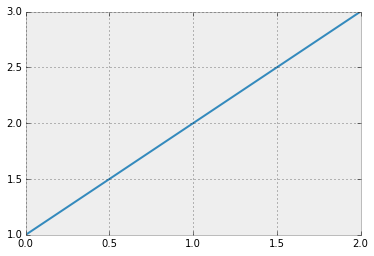

In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline



import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl




# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )




ion()

# test plotting style'
from pylab import *
plot([1,2,3])
show()


import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)



#####  One can use the initialization of the notebook styles below. It will improve *code blocks* appearance but the *markdown* cells would be poor presented!  <font color='red'>Think twice if you need it! </font>

In [5]:
import urllib2
from IPython.core.display import HTML
theme_names = ['3024-dark',
               '3024-light',
               'atelierdune-dark',
               'atelierdune-light',
               'atelierforest-dark',
               'atelierforest-light',
               'atelierheath-dark',
               'atelierheath-light',
               'atelierlakeside-dark',
               'atelierlakeside-light',
               'atelierseaside-dark',
               'atelierseaside-light',
               'bespin-dark',
               'bespin-light',
               'chalk-dark',
               'chalk-light',
               'default-dark',
               'default-light',
               'eighties-dark',
               'eighties-light',
               'grayscale-dark',
               'grayscale-light',
               'greenscreen-dark',
               'greenscreen-light',
               'isotope-dark',
               'isotope-light',
               'londontube-dark',
               'londontube-light',
               'marrakesh-dark',
               'marrakesh-light',
               'mocha-dark',
               'mocha-light',
               'monokai-dark',
               'monokai-light',
               'ocean-dark',
               'ocean-light',
               'paraiso-dark',
               'paraiso-light',
               'railscasts-dark',
               'railscasts-light',
               'shapeshifter-dark',
               'shapeshifter-light',
               'solarized-dark',
               'solarized-light',
               'tomorrow-dark',
               'tomorrow-light',
               'twilight-dark',
               'twilight-light']


url_base = 'https://raw.githubusercontent.com/nsonnad/base16-ipython-notebook/master/ipython-2/output/base16-%s.css'
style='<style>\n%s\n</style>'% urllib2.urlopen(url_base%theme_names[theme_names.index('ocean-dark')]).read() 
HTML(style)


# to restore the old styling
#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )



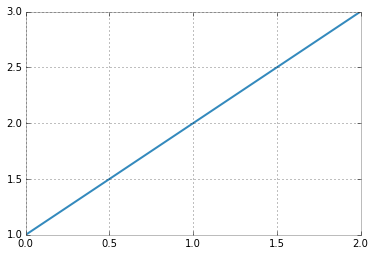

In [8]:
# test plotting style'
from pylab import *
plot([1,2,3])
show()